# Анализ WinEventLog и DNS (botsv1)

Этот ноутбук выполняет задание:
- загружает данные botsv1 в Pandas,
- находит подозрительные события в WinEventLog по EventID,
- выявляет потенциально вредоносные DNS-запросы (частота/редкость/аномальная длина/поддомены),
- визуализирует **топ‑10** наиболее распространённых подозрительных событий.

> Примечание: ноутбук рассчитан на JSON в формате Splunk/BOTS (каждая запись — отдельный JSON-объект в строке).

## 0. Установка и импорт библиотек
Если вы запускаете ноутбук локально и библиотек нет, установите:

```bash
pip install pandas matplotlib
```

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path

plt.rcParams['figure.dpi'] = 120


## 1. Загрузка данных
Укажите путь к файлу `botsv1.json` (или вашему JSON).

In [12]:
# TODO: укажите путь к вашему файлу
DATA_PATH = Path("botsv1.json")  # например: Path("/path/to/botsv1.json")

assert DATA_PATH.exists(), f"Файл не найден: {DATA_PATH.resolve()}"

# В BOTS часто используется JSON Lines (1 JSON-объект на строку)
df = pd.read_json(DATA_PATH)

print("Размер датасета:", df.shape)
display(df.head(3))


Размер датасета: (35, 3)


,preview,offset,result
0,False,41160,"{'Account_Domain': 'WAYNECORPINC', 'Account_Na..."
1,False,41161,"{'Account_Domain': 'WAYNECORPINC', 'Account_Na..."
2,False,41162,"{'Account_Domain': ['-', 'WAYNECORPINC'], 'Acc..."


In [15]:
raw = pd.read_json(DATA_PATH)
print("До нормализации:", raw.shape)

# Распаковываем вложенный словарь result
df = pd.json_normalize(raw["result"])

print("После нормализации:", df.shape)
display(df.head(3))

До нормализации: (35, 3)
После нормализации: (35, 111)


,Account_Domain,Account_Name,ComputerName,Creator_Process_ID,EventCode,EventType,Keywords,LogName,Logon_ID,Message,...,Object_Name,Object_Server,Object_Type,Privileges_Used_for_Access_Check,ReadData__or_ListDirectory_,Resource_Attributes,Restricted_SID_Count,Transaction_ID,privilege_id,vendor_privilege
0,WAYNECORPINC,we3436srv$,we3436srv.waynecorpinc.local,0xddc,4688,0,Audit Success,Security,0x3E7,A new process has been created.\n\nSubject:\n\...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WAYNECORPINC,we1159srv$,we1159srv.waynecorpinc.local,NaN,4689,0,Audit Success,Security,0x3E7,A process has exited.\n\nSubject:\n\tSecurity ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[-, WAYNECORPINC]","[-, we9028srv$]",we9028srv.waynecorpinc.local,NaN,4624,0,Audit Success,Security,"[0x0, 0x15D68DA]",An account was successfully logged on.\n\nSubj...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Нормализация и подготовка
Приводим ключевые поля к единому виду и готовим подвыборки для WinEventLog и DNS.

**Важно:** в BOTS поле EventID может встречаться как `EventCode`, `signature_id` или похожее. Ниже мы нормализуем в единое поле `event_id_norm`.

In [16]:
# Унификация поля sourcetype
if 'sourcetype' not in df.columns:
    raise ValueError("В данных нет поля 'sourcetype'. Проверьте формат файла.")

df['sourcetype'] = df['sourcetype'].astype(str)

# Выделяем WinEventLog (Security) и DNS (по ключевым словам)
win_df = df[df['sourcetype'].str.contains("WinEventLog", case=False, na=False)].copy()
dns_df = df[df['sourcetype'].str.contains("dns", case=False, na=False)].copy()

print("WinEventLog rows:", len(win_df))
print("DNS rows:", len(dns_df))

# Нормализуем Event ID для WinEventLog
def coalesce_event_id(row):
    for col in ["EventCode", "signature_id", "EventID", "eventcode"]:
        if col in row and pd.notna(row[col]):
            return row[col]
    return np.nan

if len(win_df) > 0:
    win_df['event_id_norm'] = win_df.apply(coalesce_event_id, axis=1)
    win_df['event_id_norm'] = pd.to_numeric(win_df['event_id_norm'], errors='coerce')

    # Временная метка
    if '_time' in win_df.columns:
        win_df['_time'] = pd.to_datetime(win_df['_time'], errors='coerce')
    else:
        win_df['_time'] = pd.NaT

    win_df = win_df.dropna(subset=['event_id_norm'])
    win_df['event_id_norm'] = win_df['event_id_norm'].astype(int)

    display(win_df[['sourcetype','event_id_norm','host','user','_time']].head(5))


WinEventLog rows: 35
DNS rows: 0


C:\Users\iramu\AppData\Local\Temp\ipykernel_9920\514909724.py:27: FutureWarning: Parsed string "2016-08-28 16:02:21.000 MDT" included an un-recognized timezone "MDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  win_df['_time'] = pd.to_datetime(win_df['_time'], errors='coerce')


,sourcetype,event_id_norm,host,user,_time
0,WinEventLog:Security,4688,we3436srv,we3436srv$,2016-08-28 16:02:21
1,WinEventLog:Security,4689,we1159srv,we1159srv$,2016-08-28 16:02:21
2,WinEventLog:Security,4624,we9028srv,we9028srv$,2016-08-28 16:02:20
3,WinEventLog:Security,4703,we5878srv,we5878srv$,2016-08-28 16:02:20
4,WinEventLog:Security,4703,we3997srv,we3997srv$,2016-08-28 16:02:20


## 3. Анализ WinEventLog: подозрительные EventID
Базовый набор EventID, часто используемых при расследованиях:
- **4625**: неудачный логон (brute-force)
- **4624**: успешный логон (аномалии по частоте/типу)
- **4672**: специальные привилегии назначены
- **4688**: создание процесса
- **4703**: изменение прав/привилегий
- **4720**: создание учётной записи
- **4728/4732/4756**: добавление в группы (в т.ч. админские)
- **4768/4769/4771**: Kerberos-активность (аномалии)

Список можно расширять под задачу.

In [17]:
SUSPICIOUS_EVENT_IDS = {
    4625: "Logon failure",
    4624: "Logon success (проверять аномалии)",
    4672: "Special privileges assigned",
    4688: "Process creation",
    4703: "User right adjusted (privilege change)",
    4720: "User account created",
    4728: "Added to a security-enabled global group",
    4732: "Added to a security-enabled local group",
    4756: "Added to a universal security group",
    4768: "Kerberos TGT requested",
    4769: "Kerberos service ticket requested",
    4771: "Kerberos pre-auth failed"
}

if len(win_df) > 0:
    suspicious_win = win_df[win_df['event_id_norm'].isin(SUSPICIOUS_EVENT_IDS.keys())].copy()
    suspicious_win['event_name'] = suspicious_win['event_id_norm'].map(SUSPICIOUS_EVENT_IDS)

    top_win = (suspicious_win['event_id_norm']
               .value_counts()
               .head(10)
               .rename_axis("EventID")
               .reset_index(name="count"))

    top_win['event_name'] = top_win['EventID'].map(SUSPICIOUS_EVENT_IDS)

    display(top_win)
else:
    print("WinEventLog записи не найдены — пропускаем этот блок.")


,EventID,count,event_name
0,4703,12,User right adjusted (privilege change)
1,4688,9,Process creation
2,4624,3,Logon success (проверять аномалии)


## 4. Анализ DNS: подозрительные запросы
Индикаторы:
- **частые запросы** к одному домену (beaconing),
- **редкие домены** (низкая частота),
- **аномально длинные** домены/поддомены (DGA/туннелирование),
- **многоуровневые поддомены** (туннелирование).

Пробуем автоматически определить поле домена/запроса.

In [18]:
def detect_dns_query_column(dns_df: pd.DataFrame):
    candidates = ["query", "Query", "query_name", "dns_query", "qname", "Domain", "domain", "dest_host", "record"]
    for c in candidates:
        if c in dns_df.columns:
            sample = dns_df[c].dropna().astype(str).head(20).tolist()
            if any("." in s for s in sample):
                return c

    best = None
    best_score = 0
    for c in dns_df.columns:
        if dns_df[c].dtype == object:
            sample = dns_df[c].dropna().astype(str).head(50)
            score = (sample.str.contains(r"\.", regex=True).mean()) if len(sample) else 0
            if score > best_score:
                best_score = score
                best = c
    return best

if len(dns_df) > 0:
    dns_query_col = detect_dns_query_column(dns_df)
    print("DNS query column:", dns_query_col)

    if dns_query_col is None:
        raise ValueError("Не удалось определить колонку DNS-запроса. Посмотрите dns_df.columns и укажите вручную.")

    dns_df = dns_df.copy()
    dns_df['q'] = dns_df[dns_query_col].astype(str).str.lower().str.strip()

    dns_df['q_len'] = dns_df['q'].str.len()
    dns_df['labels'] = dns_df['q'].str.split('.').apply(lambda x: len(x) if isinstance(x, list) else np.nan)
    dns_df['max_label_len'] = dns_df['q'].str.split('.').apply(lambda x: max([len(i) for i in x]) if isinstance(x, list) and len(x) else np.nan)

    # Top-10 по частоте
    top_dns_freq = dns_df['q'].value_counts().head(10).rename_axis("domain").reset_index(name="count")

    # Редкие домены (встречаются 1 раз)
    rare_dns = dns_df['q'].value_counts()
    rare_dns = rare_dns[rare_dns == 1].head(10).rename_axis("domain").reset_index(name="count")

    # Длинные домены
    suspicious_long = (dns_df[dns_df['q_len'] >= 45]['q']
                       .value_counts()
                       .head(10)
                       .rename_axis("domain")
                       .reset_index(name="count"))

    # Много поддоменов
    suspicious_many_labels = (dns_df[dns_df['labels'] >= 6]['q']
                              .value_counts()
                              .head(10)
                              .rename_axis("domain")
                              .reset_index(name="count"))

    display(top_dns_freq)
else:
    print("DNS записи не найдены — пропускаем этот блок.")


DNS записи не найдены — пропускаем этот блок.


## 5. Визуализация Top‑10
Строим отдельные графики для WinEventLog и DNS. Используем **matplotlib**.

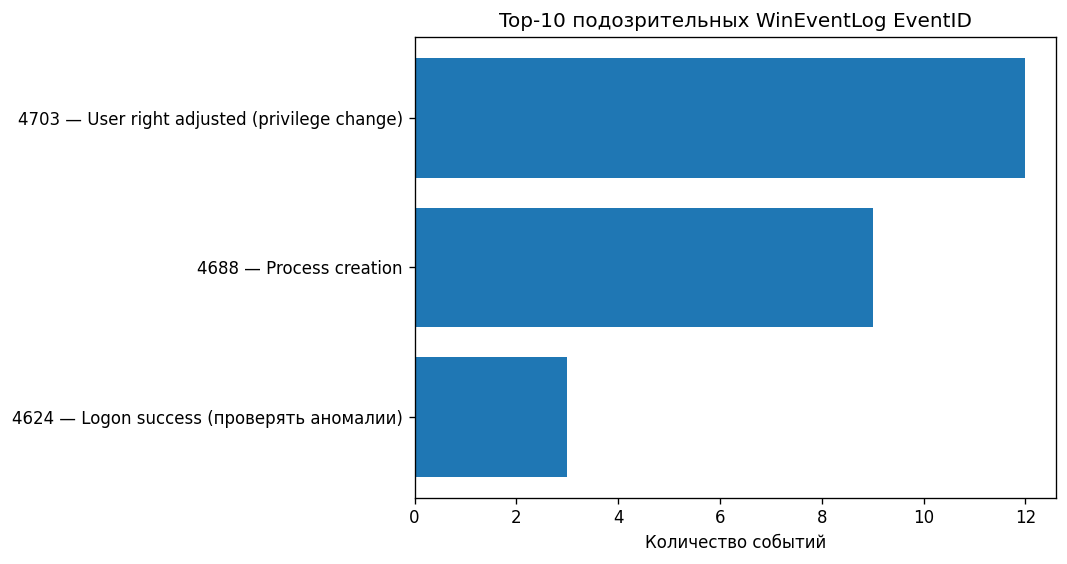

In [19]:
def barh_plot(df_plot, y_col, x_col, title, xlabel):
    plt.figure(figsize=(9, 4.8))
    df_plot = df_plot.sort_values(x_col, ascending=True)
    plt.barh(df_plot[y_col].astype(str), df_plot[x_col])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()

# WinEventLog Top-10 suspicious EventIDs
if 'top_win' in globals() and len(top_win) > 0:
    top_win_plot = top_win.copy()
    top_win_plot['label'] = top_win_plot.apply(lambda r: f"{r['EventID']} — {r['event_name']}", axis=1)
    barh_plot(top_win_plot, 'label', 'count', "Top‑10 подозрительных WinEventLog EventID", "Количество событий")

# DNS Top-10 frequent domains
if 'top_dns_freq' in globals() and len(top_dns_freq) > 0:
    barh_plot(top_dns_freq, 'domain', 'count', "Top‑10 самых частых DNS-запросов (подозрение на beaconing)", "Количество запросов")

# DNS long domains
if 'suspicious_long' in globals() and len(suspicious_long) > 0:
    barh_plot(suspicious_long, 'domain', 'count', "Top‑10 длинных DNS-доменов (возможный DGA/туннелирование)", "Количество запросов")

# DNS many labels
if 'suspicious_many_labels' in globals() and len(suspicious_many_labels) > 0:
    barh_plot(suspicious_many_labels, 'domain', 'count', "Top‑10 доменов с множеством поддоменов (возможное туннелирование)", "Количество запросов")


## 6. Примеры точечной проверки (для отчёта)
Пример: поиск PowerShell в создании процессов (EventID 4688) или в командной строке.

In [20]:
if len(win_df) > 0:
    cols = [c for c in ['New_Process_Name','Process_Name','Process_Command_Line','CommandLine','Message','_raw'] if c in win_df.columns]
    if cols:
        mask = False
        for c in cols:
            mask = mask | win_df[c].astype(str).str.contains("powershell", case=False, na=False)
        ps_events = win_df[mask].copy()
        print("Найдено событий с powershell:", len(ps_events))
        display(ps_events[['event_id_norm'] + cols].head(10))
    else:
        print("Нет колонок для поиска команд/процессов — проверьте структуру win_df.columns")


Найдено событий с powershell: 5


,event_id_norm,New_Process_Name,Process_Name,Process_Command_Line,Message,_raw
6,4689,NaN,C:\Program Files\SplunkUniversalForwarder\bin\...,NaN,A process has exited.\n\nSubject:\n\tSecurity ...,08/28/2016 22:02:20 PM\nLogName=Security\nSour...
10,4689,NaN,C:\Program Files\SplunkUniversalForwarder\bin\...,NaN,A process has exited.\n\nSubject:\n\tSecurity ...,08/28/2016 22:02:19 PM\nLogName=Security\nSour...
14,4689,NaN,C:\Program Files\SplunkUniversalForwarder\bin\...,NaN,A process has exited.\n\nSubject:\n\tSecurity ...,08/28/2016 22:02:19 PM\nLogName=Security\nSour...
16,4688,C:\Program Files\SplunkUniversalForwarder\bin\...,NaN,"""C:\Program Files\SplunkUniversalForwarder\bin...",A new process has been created.\n\nSubject:\n\...,08/28/2016 22:02:18 PM\nLogName=Security\nSour...
29,4689,NaN,C:\Program Files\SplunkUniversalForwarder\bin\...,NaN,A process has exited.\n\nSubject:\n\tSecurity ...,08/28/2016 22:02:17 PM\nLogName=Security\nSour...
